# AI-VAR

In [11]:
import numpy as np

data = np.load("atm_state_and_history.npz")

u      = data["u"]
w      = data["w"]
theta = data["theta"]
theta0 = data["theta0"]

snap_u  = data["snap_u"]
snap_w  = data["snap_w"]
snap_th = data["snap_th"]
snap_t  = data["snap_t"]

X = data["X"]
Z = data["Z"]

print("Loaded fields:", u.shape, w.shape, theta.shape)

Loaded fields: (40, 200) (40, 200) (40, 200)


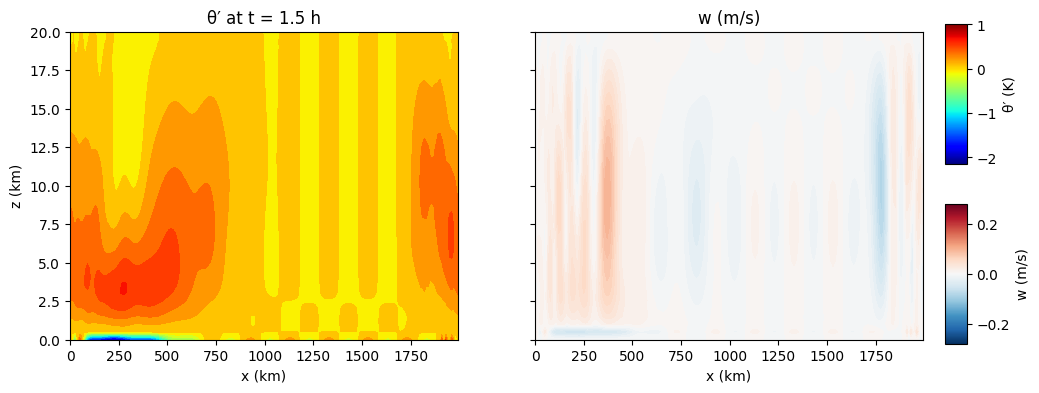

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

# ============================================================
# Plot one snapshot from loaded data (sanity check)
# ============================================================

# ------------------------
# choose snapshot index
# ------------------------
i = 3   # 0 = IC, 1 = first saved hour, etc.

# ------------------------
# coordinates
# ------------------------
X_km = X / 1e3
Z_km = Z / 1e3

# ------------------------
# select fields
# ------------------------
if i == 0:
    theta_i = theta0
    w_i = np.zeros_like(theta0)
    hour = 0.0
else:
    theta_i = snap_th[i-1]
    w_i = snap_w[i-1]
    hour = snap_t[i-1] / 3600.0

theta_p = theta_i - theta0

# ------------------------
# global limits (same logic as before)
# ------------------------
thp_all = np.concatenate([(th - theta0).ravel() for th in [theta0] + list(snap_th)])
w_all   = np.concatenate([w.ravel() for w in [np.zeros_like(snap_w[0])] + list(snap_w)])

norm_th = Normalize(vmin=thp_all.min(), vmax=thp_all.max())
norm_w  = Normalize(vmin=-np.max(np.abs(w_all)), vmax=np.max(np.abs(w_all)))

# ------------------------
# figure
# ------------------------
fig, axes = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(11, 4),
    sharex=True,
    sharey=True
)

# θ′
axes[0].contourf(
    X_km, Z_km, theta_p,
    levels=21,
    cmap="jet",
    norm=norm_th
)
axes[0].set_title("θ′ (IC)" if i == 0 else f"θ′ at t = {hour:.1f} h")
axes[0].set_xlabel("x (km)")
axes[0].set_ylabel("z (km)")

# w
axes[1].contourf(
    X_km, Z_km, w_i,
    levels=21,
    cmap="RdBu_r",
    norm=norm_w
)
axes[1].set_title("w (IC)" if i == 0 else "w (m/s)")
axes[1].set_xlabel("x (km)")

# ------------------------
# colorbars
# ------------------------
sm_th = ScalarMappable(norm=norm_th, cmap="jet")
sm_th.set_array([])

sm_w = ScalarMappable(norm=norm_w, cmap="RdBu_r")
sm_w.set_array([])

cax_th = fig.add_axes([0.92, 0.55, 0.02, 0.35])
cb_th = fig.colorbar(sm_th, cax=cax_th)
cb_th.set_label("θ′ (K)")

cax_w = fig.add_axes([0.92, 0.10, 0.02, 0.35])
cb_w = fig.colorbar(sm_w, cax=cax_w)
cb_w.set_label("w (m/s)")

plt.show()

✔ Created 2 synthetic radiosondes at t = 2.5 h
  Sonde 1: x ≈ 300.0 km (ix=30) | sigma_theta=0.02 K
  Sonde 2: x ≈ 800.0 km (ix=80) | sigma_theta=0.02 K


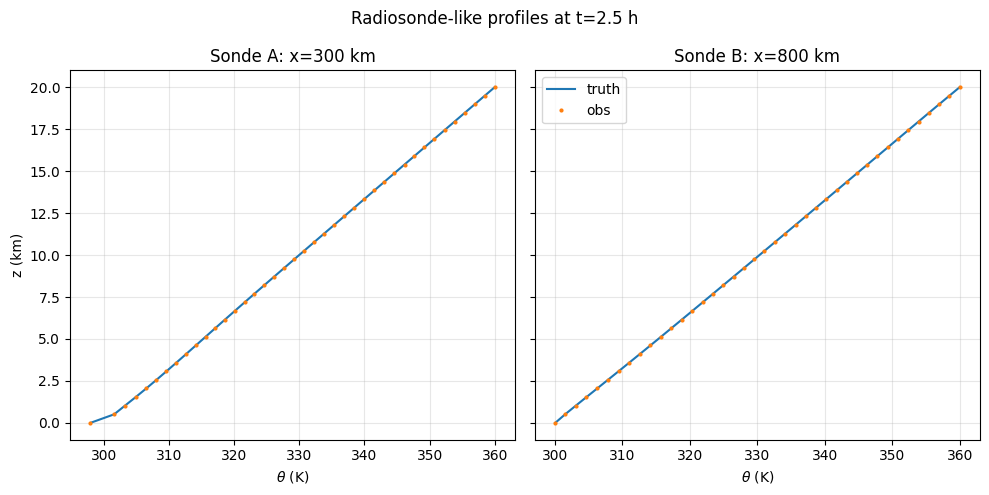

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# Synthetic radiosonde observations at two x-locations
# ============================================================

# -------------------------
# 1) Choose analysis time
# -------------------------
i = 5  # 0 = IC, 1 = first saved hour, ... (same convention as before)

if i == 0:
    theta_true = theta0.copy()
    u_true = np.zeros_like(theta0)  # if you didn't store u, ignore u below
    t_hours = 0.0
else:
    theta_true = snap_th[i-1]
    t_hours = snap_t[i-1] / 3600.0
    # if you also saved/loaded snap_u, uncomment next line:
    # u_true = snap_u[i-1]

# vertical coordinate (meters + km)
z_m  = Z[:, 0].copy()
z_km = z_m / 1e3

# -------------------------
# 2) Define 2 sonde locations (in km)
# -------------------------
sonde_x_km = [300.0, 800.0]  # choose any two positions in [0, Lx_km)
x_km = X[0, :] / 1e3

# convert to nearest grid indices
sonde_ix = [int(np.argmin(np.abs(x_km - xx))) for xx in sonde_x_km]

# -------------------------
# 3) Observation operator: extract vertical columns at those x indices
# -------------------------
def H_sonde_theta(theta_field, ix):
    """Return vertical profile theta(z) at fixed x-index ix."""
    return theta_field[:, ix].copy()

# (optional) for wind:
# def H_sonde_u(u_field, ix):
#     return u_field[:, ix].copy()

# -------------------------
# 4) Create noisy observations
# -------------------------
rng = np.random.default_rng(42)

sigma_theta = 0.02   # K (typical radiosonde order, toy level)
# sigma_u = 0.5     # m/s (optional)

obs = []
for ix in sonde_ix:
    y_theta_true = H_sonde_theta(theta_true, ix)
    y_theta_obs  = y_theta_true + rng.normal(0.0, sigma_theta, size=y_theta_true.shape)

    obs.append({
        "ix": ix,
        "x_km": float(x_km[ix]),
        "z_m": z_m,
        "theta_true": y_theta_true,
        "theta_obs": y_theta_obs,
        "sigma_theta": sigma_theta
    })

print(f"✔ Created 2 synthetic radiosondes at t = {t_hours:.1f} h")
for k,o in enumerate(obs, start=1):
    print(f"  Sonde {k}: x ≈ {o['x_km']:.1f} km (ix={o['ix']}) | sigma_theta={o['sigma_theta']} K")

# -------------------------
# 5) Quick plot: truth vs observations
# -------------------------
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

for ax, o, title in zip(axes, obs, ["Sonde A", "Sonde B"]):
    ax.plot(o["theta_true"], z_km, label="truth")
    ax.plot(o["theta_obs"],  z_km, ".", label="obs", markersize=4)
    ax.set_title(f"{title}: x={o['x_km']:.0f} km")
    ax.set_xlabel(r"$\theta$ (K)")
    ax.grid(True, alpha=0.3)

axes[0].set_ylabel("z (km)")
axes[1].legend(loc="best")
plt.suptitle(f"Radiosonde-like profiles at t={t_hours:.1f} h")
plt.tight_layout()
plt.show()


In [14]:
# ============================================================
# Save radiosonde observations to NPZ
# ============================================================

# stack profiles: shape = (n_sondes, n_z)
theta_true_all = np.stack([o["theta_true"] for o in obs], axis=0)
theta_obs_all  = np.stack([o["theta_obs"]  for o in obs], axis=0)

# metadata
sonde_ix_all   = np.array([o["ix"] for o in obs], dtype=int)
sonde_x_km_all = np.array([o["x_km"] for o in obs], dtype=float)

# (same z for all sondes)
z_m_all        = obs[0]["z_m"]
sigma_theta   = obs[0]["sigma_theta"]

# time info
t_hours_obs   = float(t_hours)
itime_index   = int(i)

np.savez(
    "radiosonde_obs_t{:03d}.npz".format(itime_index),
    theta_true = theta_true_all,
    theta_obs  = theta_obs_all,
    z_m        = z_m_all,
    sonde_ix   = sonde_ix_all,
    sonde_x_km = sonde_x_km_all,
    sigma_theta = sigma_theta,
    t_hours    = t_hours_obs,
    itime      = itime_index
)

print("✔ Saved radiosonde observations:",
      f"radiosonde_obs_t{itime_index:03d}.npz")

✔ Saved radiosonde observations: radiosonde_obs_t005.npz


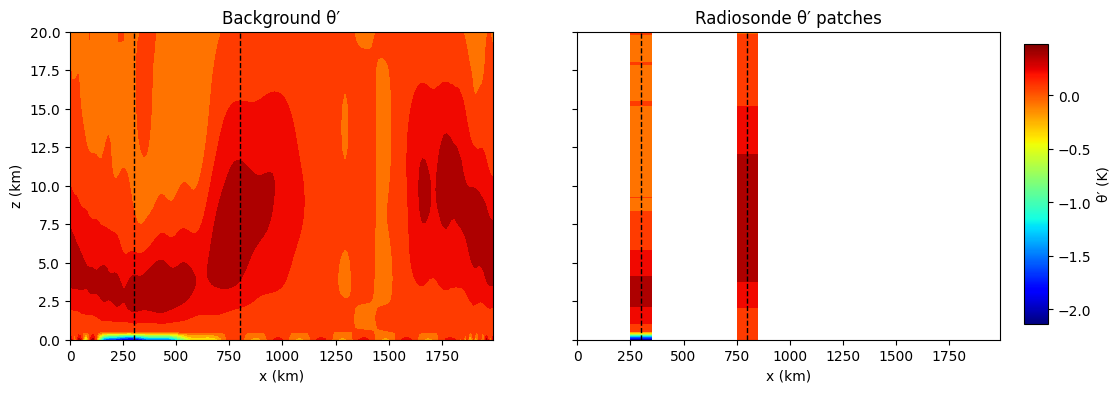

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

# ============================================================
# Background θ′ vs radiosonde θ′ patches (finite width)
# ============================================================

X_km = X / 1e3
Z_km = Z / 1e3

# ------------------------------------------------------------
# Background field
# ------------------------------------------------------------
theta_bg = theta_true.copy()
theta_p_bg = theta_bg - theta0

# ------------------------------------------------------------
# Radiosonde-only field (NaN everywhere initially)
# ------------------------------------------------------------
theta_obs_only = np.full_like(theta_bg, np.nan)

# width of radiosonde "influence" in grid points
half_width = 5   # +/- 2 grid points → visible patch

for o in obs:
    ix = o["ix"]
    ix0 = max(0, ix - half_width)
    ix1 = min(theta_bg.shape[1], ix + half_width + 1)

    # fill a small x-band with the observed vertical profile
    theta_obs_only[:, ix0:ix1] = o["theta_obs"][:, None]

theta_p_obs = theta_obs_only - theta0   # NaN-safe

# ------------------------------------------------------------
# Color limits (shared, robust)
# ------------------------------------------------------------
thp_all = np.concatenate([
    theta_p_bg[~np.isnan(theta_p_bg)],
    theta_p_obs[~np.isnan(theta_p_obs)]
])

norm_th = Normalize(vmin=thp_all.min(), vmax=thp_all.max())

# ------------------------------------------------------------
# Colormap with NaNs as white
# ------------------------------------------------------------
cmap = plt.get_cmap("jet").copy()
cmap.set_bad(color="white")

# ------------------------------------------------------------
# Figure
# ------------------------------------------------------------
fig, axes = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(12, 4),
    sharex=True,
    sharey=True
)

# LEFT: background θ′
axes[0].contourf(
    X_km, Z_km, theta_p_bg,
    levels=21,
    cmap=cmap,
    norm=norm_th
)
axes[0].set_title("Background θ′")
axes[0].set_xlabel("x (km)")
axes[0].set_ylabel("z (km)")

# mark sonde centers
for o in obs:
    axes[0].axvline(o["x_km"], color="k", linestyle="--", linewidth=1)

# RIGHT: radiosonde patches only
axes[1].contourf(
    X_km, Z_km, theta_p_obs,
    levels=21,
    cmap=cmap,
    norm=norm_th
)
axes[1].set_title("Radiosonde θ′ patches")
axes[1].set_xlabel("x (km)")

# mark sonde centers
for o in obs:
    axes[1].axvline(o["x_km"], color="k", linestyle="--", linewidth=1)

# ------------------------------------------------------------
# Shared colorbar
# ------------------------------------------------------------
sm_th = ScalarMappable(norm=norm_th, cmap=cmap)
sm_th.set_array([])

cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cb = fig.colorbar(sm_th, cax=cax)
cb.set_label("θ′ (K)")

#plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()


# AI Part Starting

In [17]:
import torch
import torch.nn as nn

# Full-domain U-Net for DA: (xb, y_patch, obs_mask) -> xa
class UNetDA(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super().__init__()

        # encoder
        self.enc1 = nn.Sequential(
            nn.Conv2d(in_channels, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(2)

        # bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU()
        )

        # decoder
        self.up2 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec2 = nn.Sequential(
            nn.Conv2d(128, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU()
        )

        self.up1 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.dec1 = nn.Sequential(
            nn.Conv2d(64, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.ReLU()
        )

        self.out = nn.Conv2d(32, out_channels, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        b  = self.bottleneck(self.pool2(e2))
        d2 = self.dec2(torch.cat([self.up2(b), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))
        return self.out(d1)

model = UNetDA(in_channels=3, out_channels=1)
print(model)


UNetDA(
  (enc1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bottleneck): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (up2): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2))
  (dec2): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (

In [37]:
import torch
import numpy as np

device = torch.device("cpu")
dtype  = torch.float32

# ------------------------------------------------------------
# Background, observations, mask
# ------------------------------------------------------------
xb = torch.from_numpy(theta_bg).to(device=device, dtype=dtype)[None, None, :, :]
y_patch = torch.from_numpy(theta_obs_only).to(device=device, dtype=dtype)[None, None, :, :]

obs_mask = torch.isfinite(y_patch).to(dtype)
y_patch  = torch.nan_to_num(y_patch, nan=0.0)

# ------------------------------------------------------------
# DA-consistent normalization (background scale)
# ------------------------------------------------------------
with torch.no_grad():
    sigma_b = torch.std(xb)
    sigma_b = torch.clamp(sigma_b, min=1e-6)

print("σ_b =", float(sigma_b))

# ------------------------------------------------------------
# Grid spacing (km)
# ------------------------------------------------------------
dx_km = float(X_km[0, 1] - X_km[0, 0])
dz_km = float(Z_km[1, 0] - Z_km[0, 0])

# ------------------------------------------------------------
# Gaussian B parameters
# ------------------------------------------------------------
Lx = 50.0
Lz = 1.0

_, _, nz, nx = xb.shape
kx = torch.fft.fftfreq(nx, d=dx_km, device=device, dtype=dtype)
kz = torch.fft.fftfreq(nz, d=dz_km, device=device, dtype=dtype)
KZ, KX = torch.meshgrid(kz, kx, indexing="ij")

# ------------------------------------------------------------
# Gaussian B spectrum + Tikhonov-regularized inverse
# ------------------------------------------------------------
B_spec = torch.exp(-0.5 * ((KX * Lx)**2 + (KZ * Lz)**2))

lam = 1e-4
B_inv_spec = B_spec / (B_spec**2 + lam)

def apply_Binv(field):
    fhat = torch.fft.fftn(field, dim=(-2, -1))
    out  = torch.fft.ifftn(fhat * B_inv_spec, dim=(-2, -1))
    return out.real

# ------------------------------------------------------------
# 3D-Var cost (physical units, NOT normalized)
# ------------------------------------------------------------
sigma_theta_t = torch.tensor(float(sigma_theta), dtype=dtype)
Rinv = 1.0 / (sigma_theta_t**2)
eps  = torch.tensor(1e-12, dtype=dtype)

def da_loss(xa):
    inc = xa - xb
    Binv_inc = apply_Binv(inc)
    Jb = 0.5 * torch.mean(inc * Binv_inc)

    innov = (xa - y_patch) * obs_mask
    nobs  = torch.sum(obs_mask) + eps
    Jo = 0.5 * Rinv * torch.sum(innov**2) / nobs

    return Jb + Jo, Jb, Jo


σ_b = 17.73517417907715


In [33]:
import torch

# ------------------------------------------------------------
# 1) Cost at background
# ------------------------------------------------------------
xa = xb.clone().requires_grad_(True)
J0, Jb0, Jo0 = da_loss(xa)

print("At background xb:")
print(f"  J  = {J0.item():.3e}")
print(f"  Jb = {Jb0.item():.3e}   (should be ~0)")
print(f"  Jo = {Jo0.item():.3e}")

# ------------------------------------------------------------
# 2) Move xa slightly toward observations
# ------------------------------------------------------------
alpha = 0.1
xa_test = xb + alpha * (y_patch - xb) * obs_mask

J1, Jb1, Jo1 = da_loss(xa_test)

print("\nAfter small move toward obs:")
print(f"  J  = {J1.item():.3e}")
print(f"  Jb = {Jb1.item():.3e}")
print(f"  Jo = {Jo1.item():.3e}")
print("  J decreased:", J1.item() < J0.item())

# ------------------------------------------------------------
# 3) Gradient check
# ------------------------------------------------------------
J0.backward()

grad_norm = xa.grad.norm().item()
print("\nGradient check:")
print(f"  ||∇J|| = {grad_norm:.3e}")
print("  finite:", torch.isfinite(xa.grad).all().item())

# ------------------------------------------------------------
# 4) B^{-1} scale selectivity test
# ------------------------------------------------------------

# random noise (small-scale)
noise = torch.randn_like(xb)

# smooth version via Gaussian low-pass (use B, not B^{-1})
with torch.no_grad():
    fhat = torch.fft.fftn(noise, dim=(-2, -1))
    smooth_spec = torch.exp(
        -0.5 * ((KX * Lx)**2 + (KZ * Lz)**2)
    )
    smooth = torch.fft.ifftn(fhat * smooth_spec, dim=(-2, -1)).real

# evaluate Jb only
_, Jb_noise, _  = da_loss(xb + 0.01 * noise)
_, Jb_smooth, _ = da_loss(xb + 0.01 * smooth)

print("\nCorrect B^{-1} scale test:")
print(f"  Jb(noise)  = {Jb_noise.item():.3e}")
print(f"  Jb(smooth) = {Jb_smooth.item():.3e}")
print("  noise penalized more:", Jb_noise.item() > Jb_smooth.item())



At background xb:
  J  = 1.476e+00
  Jb = 0.000e+00   (should be ~0)
  Jo = 1.476e+00

After small move toward obs:
  J  = 1.196e+00
  Jb = 1.092e-06
  Jo = 1.196e+00
  J decreased: True

Gradient check:
  ||∇J|| = 2.896e+00
  finite: True

Correct B^{-1} scale test:
  Jb(noise)  = 2.587e-04
  Jb(smooth) = 2.084e-05
  noise penalized more: True


In [38]:
import time
import torch

# ------------------------------------------------------------
# Normalized network input (dimensionless)
# ------------------------------------------------------------
net_input = torch.cat(
    [
        torch.zeros_like(xb),              # (xb - xb) / sigma_b
        (y_patch - xb) / sigma_b,           # normalized innovation
        obs_mask
    ],
    dim=1
)

# ------------------------------------------------------------
# Optimizer
# ------------------------------------------------------------
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# ------------------------------------------------------------
# Convergence parameters
# ------------------------------------------------------------
n_epochs    = 8000
check_every = 50
rel_tol_J   = 1e-4
grad_tol    = 1e-3
patience    = 5

# ------------------------------------------------------------
# Training loop with early stopping
# ------------------------------------------------------------
t0 = time.time()
J_prev = None
stall_count = 0

for ep in range(1, n_epochs + 1):
    optimizer.zero_grad()

    inc_hat = model(net_input)          # O(1)
    xa = xb + sigma_b * inc_hat         # back to physical units

    J, Jb, Jo = da_loss(xa)
    J.backward()

    # gradient norm
    grad_norm = 0.0
    with torch.no_grad():
        for p in model.parameters():
            if p.grad is not None:
                grad_norm += p.grad.norm()**2
    grad_norm = torch.sqrt(grad_norm).item()

    optimizer.step()

    # --------------------------------------------------------
    # Convergence check
    # --------------------------------------------------------
    if ep % check_every == 0:
        J_val = J.item()

        if J_prev is not None:
            rel_drop = abs(J_prev - J_val) / max(abs(J_prev), 1e-12)
            if rel_drop < rel_tol_J and grad_norm < grad_tol:
                stall_count += 1
            else:
                stall_count = 0

        J_prev = J_val

        if ep == check_every or ep % 500 == 0:
            elapsed = time.time() - t0
            print(
                f"ep {ep:5d} | "
                f"J={J_val:.3e} | "
                f"Jb={Jb.item():.3e} | "
                f"Jo={Jo.item():.3e} | "
                f"||∇J||={grad_norm:.2e} | "
                f"t={elapsed:.1f}s"
            )

        if stall_count >= patience:
            print(
                f"\n✔ Converged at ep {ep}: "
                f"ΔJ/J < {rel_tol_J}, ||∇J|| < {grad_tol}"
            )
            break


ep    50 | J=7.221e+07 | Jb=1.403e+06 | Jo=7.081e+07 | ||∇J||=4.24e+09 | t=1.2s
ep   500 | J=3.480e+05 | Jb=6.262e+04 | Jo=2.854e+05 | ||∇J||=2.00e+07 | t=10.7s
ep  1000 | J=4.308e+04 | Jb=1.703e+04 | Jo=2.606e+04 | ||∇J||=1.72e+06 | t=21.2s
ep  1500 | J=1.679e+04 | Jb=7.037e+03 | Jo=9.757e+03 | ||∇J||=6.01e+05 | t=31.7s
ep  2000 | J=9.915e+03 | Jb=3.849e+03 | Jo=6.066e+03 | ||∇J||=3.61e+05 | t=42.2s
ep  2500 | J=5.219e+03 | Jb=2.417e+03 | Jo=2.801e+03 | ||∇J||=4.08e+05 | t=53.0s
ep  3000 | J=3.120e+03 | Jb=1.667e+03 | Jo=1.453e+03 | ||∇J||=4.69e+05 | t=67.0s
ep  3500 | J=2.157e+03 | Jb=1.217e+03 | Jo=9.398e+02 | ||∇J||=2.67e+05 | t=79.4s
ep  4000 | J=1.578e+03 | Jb=9.206e+02 | Jo=6.573e+02 | ||∇J||=2.40e+05 | t=90.5s
ep  4500 | J=1.206e+03 | Jb=7.143e+02 | Jo=4.921e+02 | ||∇J||=1.77e+05 | t=101.3s
ep  5000 | J=9.323e+02 | Jb=5.638e+02 | Jo=3.684e+02 | ||∇J||=1.88e+05 | t=115.2s
ep  5500 | J=7.360e+02 | Jb=4.548e+02 | Jo=2.811e+02 | ||∇J||=1.26e+05 | t=138.7s
ep  6000 | J=6.037e+02 | J

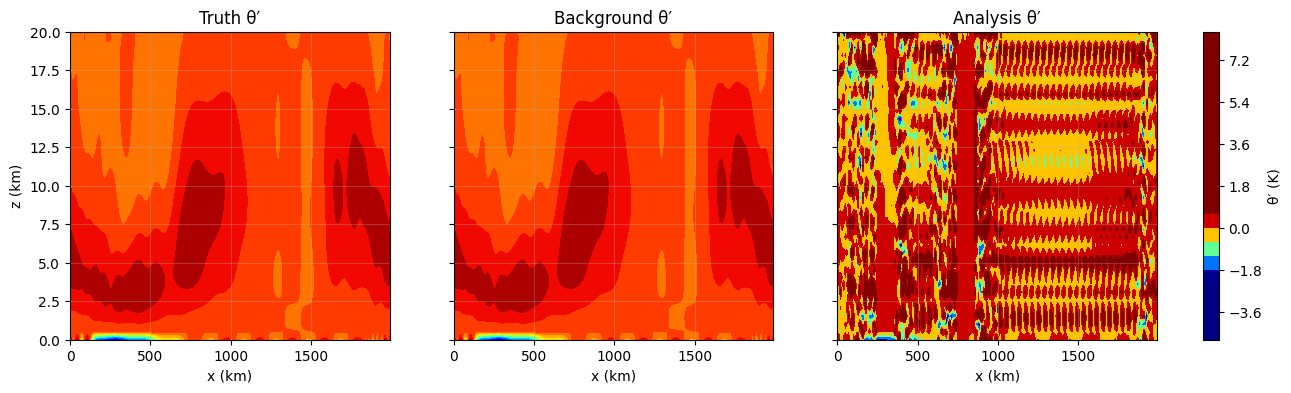

In [43]:
# ------------------------------------------------------------
# Test: compare truth, background, and analysis
# ------------------------------------------------------------
import matplotlib.pyplot as plt

with torch.no_grad():
    xa = model(net_input)

# numpy fields
xb_np = xb[0, 0].cpu().numpy()
xa_np = xb_np + xa[0, 0].cpu().numpy()
xt_np = theta_field_true            # truth field

# perturbations w.r.t. reference
xt_p = xt_np - theta0
xb_p = xb_np - theta0
xa_p = xa_np - theta0

# common color scale
vmin = xt_p.min() #min(xt_p.min(), xb_p.min(), xa_p.min())
vmax = xt_p.max() #max(xt_p.max(), xb_p.max(), xa_p.max())

fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharex=True, sharey=True)

for ax, fld, title in zip(
    axes,
    [xt_p, xb_p, xa_p],
    ["Truth θ′", "Background θ′", "Analysis θ′"]
):
    cf = ax.contourf(X_km, Z_km, fld, levels=21, vmin=vmin, vmax=vmax, cmap="jet")
    ax.set_title(title)
    ax.set_xlabel("x (km)")
    ax.grid(alpha=0.3)

axes[0].set_ylabel("z (km)")
fig.colorbar(cf, ax=axes, fraction=0.025, pad=0.04, label="θ′ (K)")
plt.show()


In [40]:
xa

tensor([[[[-0.1404,  0.2423, -0.2566,  ..., -0.3791, -0.4861, -0.3174],
          [-1.4989, -0.1257, -0.7597,  ..., -0.4835, -0.6559, -1.1755],
          [-0.2195, -0.3009, -0.4278,  ..., -0.1059, -0.0788, -0.1405],
          ...,
          [ 0.7968, -0.2071, -0.1985,  ..., -0.3810,  0.2364,  0.4113],
          [-0.4642, -1.3426, -0.0429,  ...,  2.0127,  0.7417,  0.1083],
          [ 0.8663,  2.5945, -0.5014,  ...,  1.0605,  0.2187, -0.3868]]]])

In [41]:
xb

tensor([[[[300.4831, 300.1535, 299.8346,  ..., 300.1164, 299.9170, 300.2633],
          [301.5586, 301.5571, 301.5541,  ..., 301.5559, 301.5523, 301.5538],
          [303.1242, 303.1314, 303.1338,  ..., 303.1288, 303.1276, 303.1210],
          ...,
          [356.9111, 356.9096, 356.9130,  ..., 356.9297, 356.9334, 356.9259],
          [358.4527, 358.4555, 358.4567,  ..., 358.4640, 358.4633, 358.4570],
          [360.0000, 360.0000, 360.0000,  ..., 360.0000, 360.0000, 360.0000]]]])